In [9]:
import os
import time

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

from torch.autograd import Variable

import data
from recurrent_attention import RecurrentAttention

## Overhead stuff

Helper functions for batching, resetting hidden states, etc.

In [2]:
# Training hyperparameters
eval_batch_size = 10
batch_size = 74
seq_len = 18
dropout = 0.1
clip = 2
lr = 0.02
warmup_steps = 10
decay_factor = 0.5  # Higher => faster learning rate decay
smoothing = 0.05

epochs = 100
log_interval = 150

In [3]:
# Model hyperparameters
embed_size = 512
encode_size = 256
h_size = 256
decode_size = 256
decode_out_size = 512
n_enc_layers = 1
attn_rnn_layers = 1
n_dec_layers = 1
smooth_align = True

bidirectional_attn = False

In [4]:
# Starting from sequential data, `batchify` arranges the dataset into columns.
# For instance, with the alphabet as the sequence and batch size 4, we'd get
# ┌ a g m s ┐
# │ b h n t │
# │ c i o u │
# │ d j p v │
# │ e k q w │
# └ f l r x ┘.
# These columns are treated as independent by the model, which means that the
# dependence of e. g. 'g' on 'f' can not be learned, but allows more efficient
# batch processing.
def batchify(data, batch_size):
    # Work out how cleanly we can divide the dataset into batches
    nbatches = data.size(0) // batch_size
    # Trim off any extra elements that wouldn't cleanly fit
    data = data.narrow(0, 0, nbatches * batch_size)
    # Evenly divide the data across the batches
    data = data.view(batch_size, -1).t().contiguous()
    return data

# Wraps hidden states into new Variables to detach them from their history
def repackage_hidden(h):
    if type(h) == Variable:
        return Variable(h.data)
    else:
        return tuple(repackage_hidden(v) for v in h)
    
# `get_batch` subdivides the source data into chunks of the specified length.
# E.g., using the example for the `batchify` function above and a length of 2,
# we'd get the following two Variables for i = 0:
# ┌ a g m s ┐ ┌ b h n t ┐
# └ b h n t ┘ └ c i o u ┘
# Note that despite the name of the function, the subdivison of data is not
# done along the batch dimension (i.e. dimension 1), since that was handled
# by the `batchify` function. The chunks are along dimension 0, corresponding
# to the `seq_len` dimension in the LSTM.
def get_batch(source, i, seq_len, evaluate = False):
    seq_len = min(seq_len, len(source) - 1 - i)
    data = Variable(source[i : i+seq_len], volatile = evaluate)
    target = Variable(source[i+1 : i+1+seq_len].view(-1), volatile = evaluate)
    return data, target

Label smoothing class for regularization.

In [5]:
class LabelSmoothing(nn.Module):
    def __init__(self, size, padding_idx = None, smoothing = 0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss()
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = torch.zeros_like(x.data)
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist.add_(self.smoothing / self.size)
        if self.padding_idx is not None:
            true_dist[:, self.padding_idx] = 0
            mask = torch.nonzero(target.data == self.padding_idx)
            if mask.dim() > 0:
                true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad = False)) * ntokens

Learning rate scheduler that sets the learning rate factor according to:

$$\text{lr} = d_{\text{model}}^{-0.5}\cdot\min{(\text{epoch}^{-0.5}, \text{epoch}\cdot\text{warmup}^{-1.5})}$$

This corresponds to increasing the learning rate linearly for the first $\text{warmup}$ epochs, then decreasing it proportionally to the inverse square root of the epoch number.

In [6]:
def get_lr_scheduler(h_size, warmup, optimizer):
    lrate = lambda e: h_size**(-0.5) * min((e+1)**(-decay_factor), (e+1) * warmup**(-(decay_factor+1)))
    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lrate)

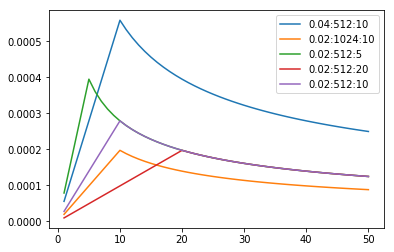

In [7]:
lrate = lambda factor, h_size, warmup: lambda e: factor*(h_size**(-0.5) * min(e**(-decay_factor), e * warmup**(-(decay_factor+1))))
opts = [
    lrate(2*lr, embed_size, warmup_steps), 
    lrate(lr, embed_size*2, warmup_steps),
    lrate(lr, embed_size, warmup_steps//2),
    lrate(lr, embed_size, warmup_steps*2),
    lrate(lr, embed_size, warmup_steps),
]
plt.plot(np.arange(1, epochs+1), [[opt(i) for opt in opts] for i in range(1, epochs+1)])
plt.legend([
    "%.4g:%d:%d" % (2*lr, embed_size, warmup_steps),
    "%.4g:%d:%d" % (lr, embed_size*2, warmup_steps),
    "%.4g:%d:%d" % (lr, embed_size, warmup_steps//2),
    "%.4g:%d:%d" % (lr, embed_size, warmup_steps*2),
    "%.4g:%d:%d" % (lr, embed_size, warmup_steps),
])

## Initialize data

In [8]:
corpus = data.Corpus(os.path.join('.', 'data', 'ptb'))
ntokens = len(corpus.dictionary)

## Model class

In [9]:
class RNNModel(nn.Module):
    def __init__(self, src_vocab, tgt_vocab, embed_size, encode_size, h_size,
                 decode_size, decode_out_size, n_enc_layers, attn_rnn_layers,
                 n_dec_layers, align_location = False, loc_align_size = 1,
                 loc_align_kernel = 1,  smooth_align = False, bidirectional_attn = False,
                 tie_wts = True, dropout = 0.1):
        super(RNNModel, self).__init__()
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        self.embed_size = embed_size
        self.encode_size = encode_size
        self.h_size = h_size
        self.decode_size = decode_size
        self.decode_out_size = decode_out_size
        self.n_enc_layers = n_enc_layers
        self.attn_rnn_layers = attn_rnn_layers
        self.n_dec_layers = n_dec_layers
        self.align_location = align_location
        self.loc_align_size = loc_align_size
        self.loc_align_kernel = loc_align_kernel
        self.smooth_align = smooth_align
        self.bidirectional_attn = bidirectional_attn
        self.tie_wts = tie_wts
        self.dropout = dropout
        
        self.drop = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        
        self.embedding = nn.Embedding(src_vocab, embed_size)
        self.encoders = nn.ModuleList([
            nn.LSTM(
                input_size = embed_size if i == 0 else encode_size,
                hidden_size = encode_size, dropout = dropout
            ) for i in range(n_enc_layers)
        ])
        self.attn = RecurrentAttention(
            in_size = encode_size, h_size = h_size, out_size = decode_size,
            align_location = align_location, loc_align_size = loc_align_size,
            loc_align_kernel = loc_align_kernel, smooth_align = smooth_align,
            num_rnn_layers = attn_rnn_layers, attn_act_fn = 'ReLU',
            dropout = dropout, bidirectional = bidirectional_attn
        )
        self.decoders = nn.ModuleList([
            nn.LSTM(
                input_size = decode_size, dropout = dropout,
                hidden_size = decode_size if i < n_dec_layers-1 else decode_out_size,
            ) for i in range(n_dec_layers)
        ])
        self.projection = nn.Linear(decode_out_size, tgt_vocab)
        if tie_wts and src_vocab == tgt_vocab and embed_size == decode_out_size:
            self.embedding.weight = self.projection.weight
        self.log_softmax = nn.LogSoftmax(dim = -1)
            
        # For visualizations
        self.save_wts = False
        self.enc_out = None
        self.dec_out = None
        
    def init(self):
        for subnet in [self.encoders, self.decoders]:
            for layer in subnet:
                for p in layer.parameters():
                    if p.dim() > 1:
                        nn.init.xavier_normal(p)
                    else:
                        p.data.fill_(0)
        for p in self.projection.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform(p)
            else:
                p.data.fill_(0)
        self.attn.init()
        
    def init_states(self, batch_size):
        encoder_states = [
            (
                Variable(torch.zeros(1, batch_size, self.encode_size)),
                Variable(torch.zeros(1, batch_size, self.encode_size))
            ) for _ in range(self.n_enc_layers)
        ]
        attn_states = self.attn.init_rnn_states(batch_size)
        decoder_states = [
            (
                Variable(torch.zeros(
                    1, batch_size, self.decode_size if i < self.n_dec_layers-1 else self.decode_out_size
                )),
                Variable(torch.zeros(
                    1, batch_size, self.decode_size if i < self.n_dec_layers-1 else self.decode_out_size
                ))
            ) for i in range(self.n_dec_layers)
        ]
        return encoder_states, attn_states, decoder_states
    
    def forward(self, inputs, states):
        enc_states, attn_states, dec_states = states
        if self.save_wts:
            self.enc_out = []
            self.dec_out = []
        
        # Embedding layer
        embeddings = self.embedding(inputs) * np.sqrt(self.embed_size)
        
        # Encoder stack
        new_enc_states = []
        enc_in = self.drop(self.relu(embeddings))
        for states, encoder in zip(enc_states, self.encoders):
            enc_out, new_enc_state = encoder(enc_in, states)
            new_enc_states.append(new_enc_state)
            if self.save_wts:
                self.enc_out.append(enc_out.data.clone())
            enc_in = enc_out
                
        # Attention mechanism
        attn_out, new_attn_states = self.attn(enc_out, attn_states)
        
        # Decoder stack
        new_dec_states = []
        dec_in = attn_out
        for states, decoder in zip(dec_states, self.decoders):
            dec_out, new_dec_state = decoder(dec_in, states)
            new_dec_states.append(new_dec_state)
            if self.save_wts:
                self.dec_out.append(dec_out.data.clone())
            dec_in = dec_out
        
        # Projection layer
        logits = self.projection(dec_out)
        output = self.log_softmax(logits)
        
        return output, (new_enc_states, new_attn_states, new_dec_states)
    
    def train(self, mode = True, save_wts = False):
        super(RNNModel, self).train(mode)
        self.attn.save_attn_wts = save_wts
        self.save_wts = save_wts
        
    def eval(self, save_wts = True):
        super(RNNModel, self).eval()
        self.attn.save_attn_wts = save_wts
        self.save_wts = save_wts

## Initialize model, criterion, optimizer, and learning rate scheduler

In [10]:
model = RNNModel(
    src_vocab = ntokens, tgt_vocab = ntokens, embed_size = embed_size,
    encode_size = encode_size, h_size = h_size, decode_size = decode_size,
    decode_out_size = decode_out_size, n_enc_layers = n_enc_layers,
    attn_rnn_layers = attn_rnn_layers, n_dec_layers = n_dec_layers,
    dropout = dropout, smooth_align = smooth_align
)
model.init()
criterion = LabelSmoothing(ntokens, smoothing = smoothing)
optimizer = optim.Adam(
    model.parameters(), lr = lr, betas = (0.9, 0.98), eps = 1e-9
)
lr_scheduler = get_lr_scheduler(embed_size, warmup_steps, optimizer)
# Reference
nparams = sum([p.numel() for p in model.parameters()])
print('Model parameters: %d' % nparams)

Model parameters: 8481297


## Train
Ready the data

In [11]:
train_data = batchify(corpus.train, batch_size)
val_data = batchify(corpus.valid, eval_batch_size)
test_data = batchify(corpus.test, eval_batch_size)
train_data.size(), val_data.size(), test_data.size()

(torch.Size([12562, 74]), torch.Size([7376, 10]), torch.Size([8243, 10]))

Define training and validation loops

In [12]:
def train():
    # Use random length sequences
    seq_lens = []
    tot_len = 0
    jitter = 0.15 * seq_len
    num_data = train_data.size(0)
    while tot_len < num_data - 2:
        if num_data - tot_len - 2 <= seq_len + jitter:
            slen = num_data - tot_len - 2
        else:
            slen = int(np.random.normal(seq_len, jitter))
            if slen <= 0:
                slen = seq_len    # eh
            if tot_len + slen >= num_data - jitter - 2:
                slen = num_data - tot_len - 2
        seq_lens.append(slen)
        tot_len += slen
    i_cumseq = [0] + list(np.cumsum(seq_lens)[:-1])
    idx = np.arange(len(seq_lens))
    np.random.shuffle(idx)
    # Turn on training mode
    model.train(save_wts = False)
    # Initialize RNN states
    states = model.init_states(batch_size)
    # Prep metainfo
    total_loss = 0
    total_epoch_loss = 0
    start_time = time.time()
    for batch, i in enumerate(idx):
        # Get training data
        data, targets = get_batch(train_data, i_cumseq[i], seq_lens[i])
        # Repackage the hidden states
        states = repackage_hidden(states)
        # Zero out gradients
        model.zero_grad()
        
        # Run the model forward
        output, _states = model(data, states)
        if np.isnan(output.data).any():
            return 0, total_epoch_loss[0], data, targets, states, _states
        # Calculate loss
        loss = criterion(output.view(-1, ntokens), targets)
        if np.isnan(loss.data[0]):
            return 1, total_epoch_loss[0], data, targets, states, _states
        states = _states
        # Propagate loss gradient backwards
        loss.backward()
        # Clip gradients
        if batch % log_interval == 0 and batch > 0:
            # Save gradient statistics before they're changed cuz we'll be logging this batch
            parameters = [p for p in model.parameters() if p.grad is not None]
            # Calculate the largest (absolute) gradient of all elements in the model parameters
            max_grad = max([p.grad.data.abs().max() for p in parameters])
        total_norm = nn.utils.clip_grad_norm(model.parameters(), clip)
        # Scale the batch learning rate so that shorter sequences aren't "stronger"
        scaled_lr = lr_scheduler.get_lr()[0] * np.sqrt(seq_lens[i] / seq_len)
        for param_group in optimizer.param_groups:
            param_group['lr'] = scaled_lr
        # Update parameters
        optimizer.step()
        
        # Get some metainfo
        total_loss += loss.data
        total_epoch_loss += loss.data * data.size(0)
        if batch % log_interval == 0 and batch > 0:
            elapsed = time.time() - start_time
            cur_loss = total_loss[0] / log_interval
            print(' b {:3d}/{:3d} >> {:6.1f} ms/b | lr: {:8.2g} | grad norm: {:4.2f} | max abs grad: {:7.3f} | loss: {:4.2f} | perp.: {:6.2f}'.format(
                batch, len(seq_lens), elapsed * 1000/log_interval, scaled_lr, total_norm, max_grad, cur_loss, np.exp(cur_loss)
            ))
            total_loss = 0
            start_time = time.time()
    return -1, total_epoch_loss[0] / num_data, None, None, None, None

In [13]:
def evaluate(data_src, save_wts = True):
    model.eval(save_wts = save_wts)
    total_loss = 0
    states = model.init_states(eval_batch_size)
    for i in range(0, data_src.size(0) - 1, seq_len):
        # Get data
        data, targets = get_batch(data_src, i, seq_len, evaluate = True)
        # Repackage the hidden states
        states = repackage_hidden(states)
        # Evaluate
        output, states = model(data, states)
        # Calculate loss
        loss = criterion(output.view(-1, ntokens), targets)
        total_loss += loss.data * data.size(0)
    return total_loss[0] / data_src.size(0)

Train and evaluate

In [14]:
WIDTH = 112
CAUSES = ['output', 'grad']
for epoch in range(epochs):
    lr_scheduler.step()
    print('Epoch {:3d}/{:3d}) lr = {:0.4g}{}'.format(epoch+1, epochs, np.mean(lr_scheduler.get_lr()[0]), ' (warmup)' if epoch < warmup_steps else ''))
    start_time = time.time()
    stat, train_loss, data, targets, states, nstates = train()
    if stat in list(range(len(CAUSES))):
        c = CAUSES[stat]
        n = (WIDTH - len(c) - 4) // 2
        print('\n' + (' '*n) + 'NaN ' + c)
        break
    elapsed = time.time() - start_time
    val_loss = evaluate(val_data, save_wts = False)
    max_param = max([p.data.abs().max() for p in model.parameters() if p.grad is not None])
    print('-' * WIDTH)
    print('Elapsed time: {:6.2f} sec | train_loss: {:5.2f} | train_perp: {:6.2f} | valid_loss: {:5.2f} | valid_perp.: {:6.2f}'.format(
        elapsed, train_loss, np.exp(train_loss), val_loss, np.exp(val_loss)
    ))
    print('=' * WIDTH)
    print('\n')

Epoch   1/ 50) lr = 2.795e-05 (warmup)
 b 150/711 >> 2320.6 ms/b | lr:  2.8e-05 | grad norm: 2.02 | max abs grad:   0.048 | loss: 7.78 | perp.: 2396.89
 b 300/711 >> 2383.5 ms/b | lr:  2.7e-05 | grad norm: 0.54 | max abs grad:   0.011 | loss: 6.31 | perp.: 551.07
 b 450/711 >> 2336.7 ms/b | lr:  2.9e-05 | grad norm: 0.58 | max abs grad:   0.007 | loss: 6.17 | perp.: 478.14
 b 600/711 >> 2483.9 ms/b | lr:  2.5e-05 | grad norm: 0.67 | max abs grad:   0.010 | loss: 6.18 | perp.: 481.74
----------------------------------------------------------------------------------------------------------------
Elapsed time: 1703.47 sec | train_loss:  6.53 | train_perp: 683.23 | valid_loss:  6.13 | valid_perp.: 459.13


Epoch   2/ 50) lr = 5.59e-05 (warmup)
 b 150/717 >> 2322.6 ms/b | lr:  5.4e-05 | grad norm: 0.52 | max abs grad:   0.005 | loss: 6.21 | perp.: 495.25
 b 300/717 >> 2275.9 ms/b | lr:  6.5e-05 | grad norm: 0.52 | max abs grad:   0.008 | loss: 6.17 | perp.: 476.92
 b 450/717 >> 2357.2 ms/b 

 b 150/722 >> 2292.8 ms/b | lr:  0.00026 | grad norm: 1.07 | max abs grad:   0.023 | loss: 5.04 | perp.: 154.31
 b 300/722 >> 2221.6 ms/b | lr:  0.00025 | grad norm: 1.21 | max abs grad:   0.033 | loss: 4.98 | perp.: 145.10
 b 450/722 >> 2253.9 ms/b | lr:  0.00024 | grad norm: 1.26 | max abs grad:   0.029 | loss: 4.97 | perp.: 143.90
 b 600/722 >> 2278.8 ms/b | lr:  0.00028 | grad norm: 2.03 | max abs grad:   0.050 | loss: 4.94 | perp.: 139.18
----------------------------------------------------------------------------------------------------------------
Elapsed time: 1638.15 sec | train_loss:  4.98 | train_perp: 145.04 | valid_loss:  4.95 | valid_perp.: 140.50


Epoch  12/ 50) lr = 0.0002552
 b 150/730 >> 2265.1 ms/b | lr:  0.00024 | grad norm: 1.01 | max abs grad:   0.032 | loss: 4.88 | perp.: 132.15
 b 300/730 >> 2246.1 ms/b | lr:  0.00026 | grad norm: 1.53 | max abs grad:   0.070 | loss: 4.89 | perp.: 132.41
 b 450/730 >> 2204.4 ms/b | lr:  0.00023 | grad norm: 1.28 | max abs grad:

 b 300/715 >> 2305.0 ms/b | lr:  0.00017 | grad norm: 2.95 | max abs grad:   0.122 | loss: 4.02 | perp.:  55.57
 b 450/715 >> 2314.2 ms/b | lr:  0.00017 | grad norm: 2.26 | max abs grad:   0.100 | loss: 3.98 | perp.:  53.63
 b 600/715 >> 2265.2 ms/b | lr:  0.00019 | grad norm: 1.83 | max abs grad:   0.069 | loss: 3.95 | perp.:  51.96
----------------------------------------------------------------------------------------------------------------
Elapsed time: 1648.64 sec | train_loss:  4.03 | train_perp:  56.14 | valid_loss:  4.30 | valid_perp.:  73.73


Epoch  22/ 50) lr = 0.0001884
 b 150/716 >> 2315.4 ms/b | lr:  0.00017 | grad norm: 2.33 | max abs grad:   0.216 | loss: 4.00 | perp.:  54.51
 b 300/716 >> 2286.4 ms/b | lr:  0.00019 | grad norm: 2.29 | max abs grad:   0.109 | loss: 3.97 | perp.:  52.93
 b 450/716 >> 2276.8 ms/b | lr:   0.0002 | grad norm: 3.67 | max abs grad:   0.100 | loss: 3.95 | perp.:  51.90
 b 600/716 >> 2352.9 ms/b | lr:  0.00017 | grad norm: 2.25 | max abs grad:

 b 450/720 >> 2324.9 ms/b | lr:  0.00016 | grad norm: 2.33 | max abs grad:   0.094 | loss: 3.46 | perp.:  31.77
 b 600/720 >> 2304.3 ms/b | lr:  0.00017 | grad norm: 6.07 | max abs grad:   0.225 | loss: 3.48 | perp.:  32.50
----------------------------------------------------------------------------------------------------------------
Elapsed time: 1644.21 sec | train_loss:  3.49 | train_perp:  32.62 | valid_loss:  5.91 | valid_perp.: 367.35


Epoch  32/ 50) lr = 0.0001563
 b 150/717 >> 2315.8 ms/b | lr:  0.00013 | grad norm: 3.08 | max abs grad:   0.206 | loss: 3.74 | perp.:  42.09
 b 300/717 >> 2303.0 ms/b | lr:  0.00015 | grad norm: 3.35 | max abs grad:   0.146 | loss: 3.36 | perp.:  28.85
 b 450/717 >> 2201.2 ms/b | lr:  0.00017 | grad norm: 2.33 | max abs grad:   0.073 | loss: 3.36 | perp.:  28.82
 b 600/717 >> 2319.9 ms/b | lr:  0.00014 | grad norm: 1.98 | max abs grad:   0.090 | loss: 3.39 | perp.:  29.55
--------------------------------------------------------------------------

 b 600/722 >> 2274.5 ms/b | lr:  0.00012 | grad norm: 2.28 | max abs grad:   0.085 | loss: 3.06 | perp.:  21.40
----------------------------------------------------------------------------------------------------------------
Elapsed time: 1685.76 sec | train_loss:  3.09 | train_perp:  21.99 | valid_loss:  2.98 | valid_perp.:  19.77


Epoch  42/ 50) lr = 0.0001364
 b 150/717 >> 2302.7 ms/b | lr:  0.00014 | grad norm: 7.43 | max abs grad:   0.217 | loss: 3.13 | perp.:  22.77
 b 300/717 >> 2489.5 ms/b | lr:  0.00015 | grad norm: 5.84 | max abs grad:   0.201 | loss: 3.01 | perp.:  20.27
 b 450/717 >> 2567.6 ms/b | lr:  0.00012 | grad norm: 2.46 | max abs grad:   0.122 | loss: 2.99 | perp.:  19.92
 b 600/717 >> 2405.8 ms/b | lr:  0.00013 | grad norm: 2.63 | max abs grad:   0.079 | loss: 3.04 | perp.:  20.84
----------------------------------------------------------------------------------------------------------------
Elapsed time: 1745.13 sec | train_loss:  3.07 | train_perp:  21.51 | vali

In [ ]:
WIDTH = 112
CAUSES = ['output', 'grad']
for epoch in range(epochs, 2*epochs):
    lr_scheduler.step()
    print('Epoch {:3d}/{:3d}) lr = {:0.4g}{}'.format(epoch+1, 2*epochs, np.mean(lr_scheduler.get_lr()[0]), ' (warmup)' if epoch < warmup_steps else ''))
    start_time = time.time()
    stat, train_loss, data, targets, states, nstates = train()
    if stat in list(range(len(CAUSES))):
        c = CAUSES[stat]
        n = (WIDTH - len(c) - 4) // 2
        print('\n' + (' '*n) + 'NaN ' + c)
        break
    elapsed = time.time() - start_time
    val_loss = evaluate(val_data, save_wts = False)
    max_param = max([p.data.abs().max() for p in model.parameters() if p.grad is not None])
    print('-' * WIDTH)
    print('Elapsed time: {:6.2f} sec | train_loss: {:5.2f} | train_perp: {:6.2f} | valid_loss: {:5.2f} | valid_perp.: {:6.2f}'.format(
        elapsed, train_loss, np.exp(train_loss), val_loss, np.exp(val_loss)
    ))
    print('=' * WIDTH)
    print('\n')

Epoch  51/100) lr = 0.0001238
 b 150/724 >> 3601.0 ms/b | lr:  0.00013 | grad norm: 5.01 | max abs grad:   0.124 | loss: 2.77 | perp.:  15.99
 b 300/724 >> 3016.5 ms/b | lr:  0.00011 | grad norm: 3.78 | max abs grad:   0.274 | loss: 2.77 | perp.:  15.94
 b 450/724 >> 2900.0 ms/b | lr:  0.00013 | grad norm: 4.25 | max abs grad:   0.118 | loss: 2.73 | perp.:  15.39
 b 600/724 >> 2954.8 ms/b | lr:  0.00012 | grad norm: 3.35 | max abs grad:   0.086 | loss: 2.75 | perp.:  15.70
----------------------------------------------------------------------------------------------------------------
Elapsed time: 2237.45 sec | train_loss:  2.78 | train_perp:  16.19 | valid_loss:  3.13 | valid_perp.:  22.79


Epoch  52/100) lr = 0.0001226
 b 150/732 >> 2837.8 ms/b | lr:  0.00012 | grad norm: 3.22 | max abs grad:   0.157 | loss: 2.68 | perp.:  14.64
 b 300/732 >> 2853.8 ms/b | lr:   0.0001 | grad norm: 2.83 | max abs grad:   0.128 | loss: 2.73 | perp.:  15.38
 b 450/732 >> 2863.8 ms/b | lr:  0.00012 | g

 b 300/721 >> 2973.1 ms/b | lr:  0.00012 | grad norm: 5.01 | max abs grad:   0.185 | loss: 2.59 | perp.:  13.38
 b 450/721 >> 2938.4 ms/b | lr:   0.0001 | grad norm: 3.25 | max abs grad:   0.116 | loss: 2.49 | perp.:  12.02
 b 600/721 >> 2997.1 ms/b | lr:   0.0001 | grad norm: 4.49 | max abs grad:   0.291 | loss: 2.59 | perp.:  13.28
----------------------------------------------------------------------------------------------------------------
Elapsed time: 2157.32 sec | train_loss:  2.58 | train_perp:  13.21 | valid_loss:  2.66 | valid_perp.:  14.28


Epoch  62/100) lr = 0.0001123
 b 150/711 >> 3051.2 ms/b | lr:  0.00012 | grad norm: 5.52 | max abs grad:   0.172 | loss: 2.74 | perp.:  15.54
 b 300/711 >> 3021.8 ms/b | lr:  9.9e-05 | grad norm: 3.50 | max abs grad:   0.148 | loss: 2.55 | perp.:  12.86
 b 450/711 >> 2972.5 ms/b | lr:  0.00011 | grad norm: 2.58 | max abs grad:   0.082 | loss: 2.52 | perp.:  12.39
 b 600/711 >> 3082.8 ms/b | lr:  0.00012 | grad norm: 3.57 | max abs grad:

In [ ]:
if stat in list(range(len(CAUSES))):
    params = [p for p in model.parameters() if p.grad is not None]
    print(any([np.isnan(p.data).any() for p in params]), any([np.isnan(p.grad.data).any() for p in params]))
    
    enc_states, attn_states, dec_states = states
    relu = nn.ReLU()
    log_softmax = nn.LogSoftmax(dim = -1)
    
    embeddings = model.embedding(data)
    enc_out, new_enc_states = model.encoder(model.drop(embeddings))
    attn_out, new_attn_states = model.attn(enc_out, attn_states)
    dec_out, new_dec_states = model.decoder(relu(attn_out))
    output = model.projection(dec_out)
    
    print([
        np.isnan(p.data).any() for p in [embeddings, enc_out, attn_out, dec_out, output]
    ])

In [ ]:
test_loss = evaluate(test_data, save_wts = True)
print('test_loss: {:5.2f} | test_perplexity: {:5.2f}'.format(
    test_loss, np.exp(test_loss)
))

## Evaluate predictions

In [ ]:
nb = 4
model.eval(save_wts = True)
# Get some data from a random point in the test_data set
states = model.init_states(nb)
data, targets = get_batch(test_data, 120, seq_len, evaluate = True)
data = data[:,:nb].contiguous()
targets = targets.view(seq_len, -1)[:,:nb].contiguous()

In [ ]:
# Run the model forward
output, states = model(data, states)
# Convert the output log probabilities to normal probabilities
output = output.exp()
# Get the argmax of each step in the output
output_p, output_idx = output.max(dim = -1)

Compare the predicted output word indices to the targets

In [ ]:
targets = targets.t()
output_idx = output_idx.t()
for i in range(nb):
    # Print the output with the targets
    seqs = torch.cat([targets[i].unsqueeze(0), output_idx[i].unsqueeze(0)], 0)
    # Number incorrectly predicted
    num_incorrect = (targets[i] != output_idx[i]).sum()
    print('%d incorrectly predicted\n' % num_incorrect[0], seqs)

## Visualizations
List of modules in the model for reference:

In [ ]:
modules = list(model.modules())
list(enumerate(modules))

Some basic weight heat maps to start:

In [ ]:
embed_wts = np.array(modules[3].weight.data)
embed_norm = (embed_wts - embed_wts.mean()) / (embed_wts.max() - embed_wts.min())
plt.imshow(embed_norm, aspect = 'auto', cmap = 'jet')
plt.xlabel('dim'); plt.ylabel('word index');
plt.title('Embedding layer')
plt.colorbar()
embed_wts.shape

In [ ]:
attn = modules[6]

In [ ]:
attn_wts = np.array(attn.attention.weight.data)
attn_norm = (attn_wts - attn_wts.mean()) / (attn_wts.max() - attn_wts.min())
plt.imshow(attn_norm, aspect = 'auto', cmap = 'jet')
plt.xlabel('d_input+d_state+d_output'); plt.ylabel('d_output')
plt.title('Output attention sublayer (in attention mechanism)')
plt.colorbar()
attn_wts.shape

Sequence attention visualization by mapping the alignment weights (in the attention mechanism) at each step of the input:

In [ ]:
cols = 2
rows = nb//cols
fig, axs = plt.subplots(rows, cols, figsize = (30, 20))
for b in range(nb):
    wts = attn.attn_wts[:,b,:]
    wts_mean = wts.mean()
    wts_max = wts.max()
    wts_min = wts.min()
    norm = (wts - wts_mean) / (wts_max - wts_min)
    r = b // cols
    c = b % cols
    ax = axs[r, c]
    im = ax.imshow(wts, aspect = 'auto', cmap = 'jet')
    # Fix labels
    xlabels = list(targets[b].data)
    ax.set_xticks(range(seq_len))
    ax.set_xticklabels(xlabels)
    ax.set_xlabel('Targets')
    ylabels = list(data[:,b].data)
    ax.set_yticks(range(seq_len))
    ax.set_yticklabels(ylabels)
    ax.set_ylabel('Inputs')
    ax.set_title('Example %d' % b)
    fig.colorbar(im, ax = ax)
plt.show()